In [15]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
def load_imdb_data(directory):
    """
    Loads IMDb dataset from a directory containing 'pos' and 'neg' subdirectories.
    """
    data = []
    labels = []

    for label in ['pos', 'neg']:
        path = os.path.join(directory, label)
        for file_name in os.listdir(path):
            if file_name.endswith('.txt'):
                with open(os.path.join(path, file_name), 'r', encoding='utf-8') as f:
                    review = f.read()
                    data.append(review)
                    labels.append(1 if label == 'pos' else 0)  # 1 for positive, 0 for negative

    return pd.DataFrame({'review': data, 'sentiment': labels})

In [6]:
train_directory = 'datasets/aclImdb/train'  # Adjust this to your path
df = load_imdb_data(train_directory)

In [7]:
def preprocess_text(text):
    """
    Preprocess the review text: Remove unwanted characters, stopwords, and lowercase the text.
    """
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    
    # Lowercase the text
    text = text.lower()
    
    # Tokenize and remove stopwords
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

In [8]:
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [9]:
X = df['cleaned_review']
y = df['sentiment']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for simplicity
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [12]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [13]:
y_pred = model.predict(X_test_tfidf)

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

Accuracy: 87.76%
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2485
           1       0.87      0.89      0.88      2515

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [16]:
max_words = 5000  # Limit to the top 5000 words in the dataset
max_sequence_length = 200  # Pad/truncate reviews to a maximum length of 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [17]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [18]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 4. Model Training
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/5
313/313 [==============================] - 301s 927ms/step - loss: 0.3525 - accuracy: 0.8533 - val_loss: 0.3380 - val_accuracy: 0.8552
Epoch 2/5
313/313 [==============================] - 296s 947ms/step - loss: 0.2701 - accuracy: 0.8922 - val_loss: 0.3071 - val_accuracy: 0.8712
Epoch 3/5
313/313 [==============================] - 286s 914ms/step - loss: 0.2189 - accuracy: 0.9152 - val_loss: 0.3374 - val_accuracy: 0.8586
Epoch 4/5
313/313 [==============================] - 288s 919ms/step - loss: 0.1896 - accuracy: 0.9272 - val_loss: 0.3445 - val_accuracy: 0.8574
Epoch 5/5
313/313 [==============================] - 298s 951ms/step - loss: 0.1723 - accuracy: 0.9347 - val_loss: 0.3755 - val_accuracy: 0.8592


In [21]:
lstm_predictions = model.predict(X_test_pad)
lstm_predictions = [1 if p >= 0.5 else 0 for p in lstm_predictions]

157/157 [==============================] - 6s 32ms/step


In [22]:
lstm_accuracy = accuracy_score(y_test, lstm_predictions)
print(f'LSTM Accuracy: {lstm_accuracy * 100:.2f}%')
print(classification_report(y_test, lstm_predictions))

LSTM Accuracy: 87.12%
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2485
           1       0.86      0.89      0.87      2515

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [24]:
logistic_accuracy = accuracy_score(y_test, y_pred)  # Logistic Regression accuracy
lstm_accuracy = accuracy_score(y_test, lstm_predictions)  # LSTM accuracy

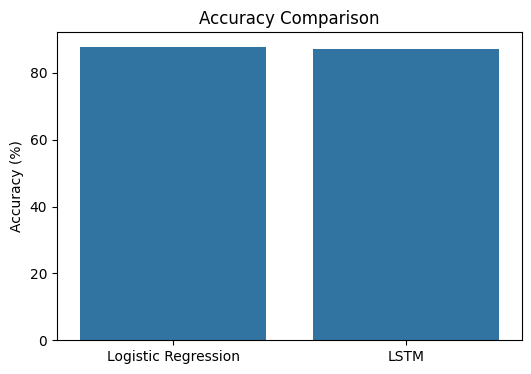

In [25]:
plt.figure(figsize=(6, 4))
models = ['Logistic Regression', 'LSTM']
accuracies = [logistic_accuracy * 100, lstm_accuracy * 100]
sns.barplot(x=models, y=accuracies)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.show()

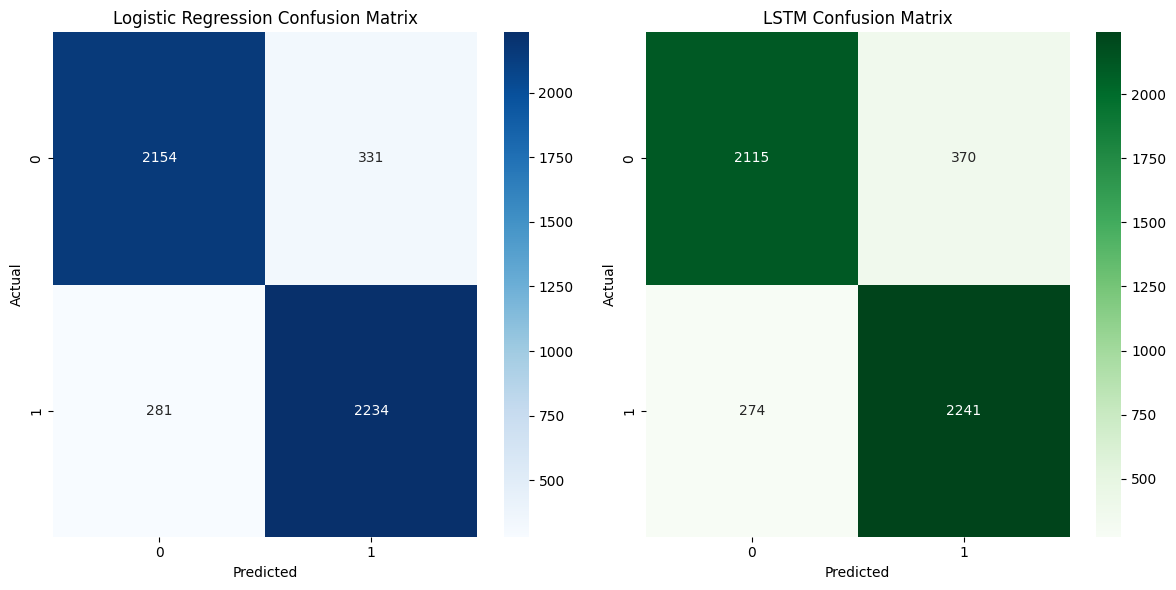

In [26]:
logistic_cm = confusion_matrix(y_test, y_pred)
lstm_cm = confusion_matrix(y_test, lstm_predictions)

# Plotting Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Logistic Regression Confusion Matrix
sns.heatmap(logistic_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# LSTM Confusion Matrix
sns.heatmap(lstm_cm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title('LSTM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

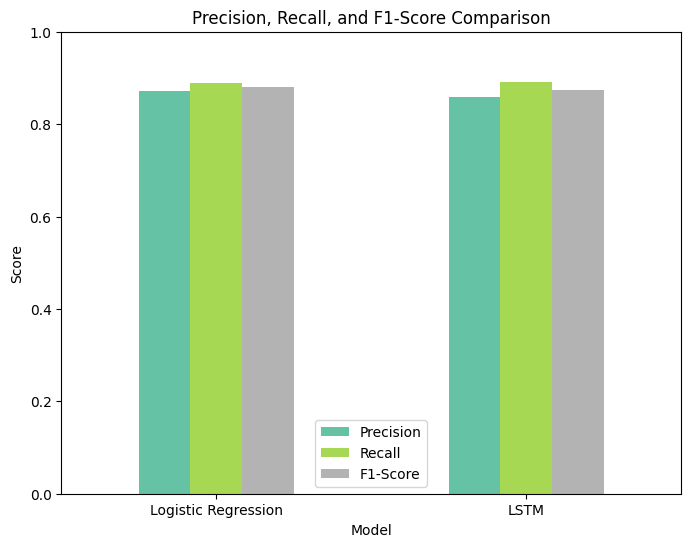

In [27]:
logistic_metrics = precision_recall_fscore_support(y_test, y_pred, average='binary')
lstm_metrics = precision_recall_fscore_support(y_test, lstm_predictions, average='binary')

# Extract metrics
logistic_precision, logistic_recall, logistic_f1, _ = logistic_metrics
lstm_precision, lstm_recall, lstm_f1, _ = lstm_metrics

# Create DataFrame for easy plotting
import pandas as pd
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'LSTM'],
    'Precision': [logistic_precision, lstm_precision],
    'Recall': [logistic_recall, lstm_recall],
    'F1-Score': [logistic_f1, lstm_f1]
})

# Bar chart for Precision, Recall, and F1-Score comparison
metrics_df.set_index('Model').plot(kind='bar', figsize=(8, 6), ylim=(0, 1), colormap='Set2')
plt.title('Precision, Recall, and F1-Score Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()